In [2]:
import math
import pandas as pd
import numpy as np
from numpy import percentile
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use({'figure.facecolor':'white'})
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.api import ExponentialSmoothing

### Data Import

In [3]:
df = pd.read_csv('../../data/dataset.csv', parse_dates=['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131184 entries, 0 to 131183
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   ou        131184 non-null  float64       
 1   datetime  131184 non-null  datetime64[ns]
 2   cheques   131184 non-null  int64         
 3   rto       131184 non-null  float64       
 4   n_sku     131184 non-null  int64         
 5   cnt       131184 non-null  int64         
 6   cashnum   131184 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 7.0 MB


In [4]:
df.head()

,ou,datetime,cheques,rto,n_sku,cnt,cashnum
0,468.0,2019-11-16 08:00:00,34,8003.0,137,173,3
1,468.0,2019-11-16 09:00:00,40,20129.0,283,517,2
2,468.0,2019-11-16 10:00:00,41,15782.0,185,227,2
3,468.0,2019-11-16 11:00:00,63,39451.0,386,659,4
4,468.0,2019-11-16 12:00:00,84,57330.0,635,992,4


### Visualization timeseries

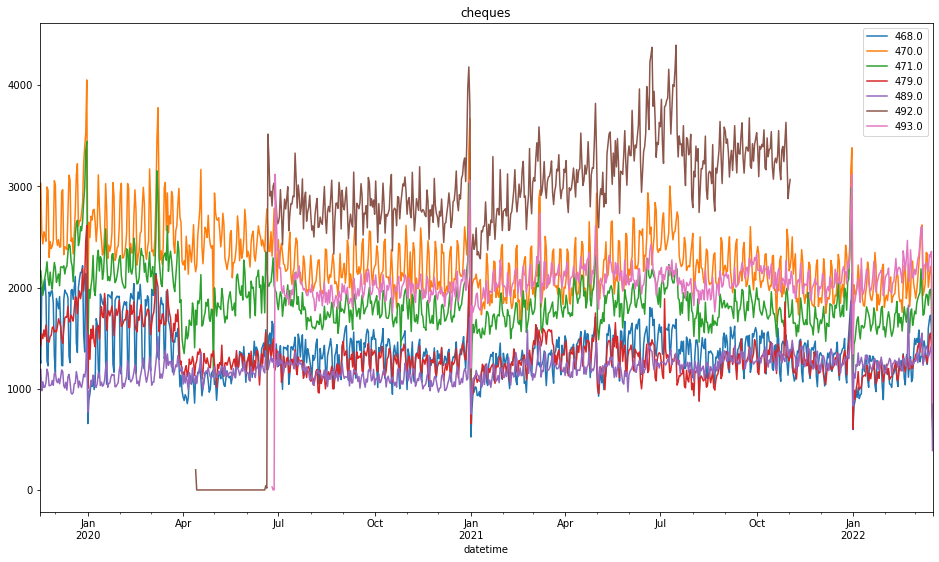

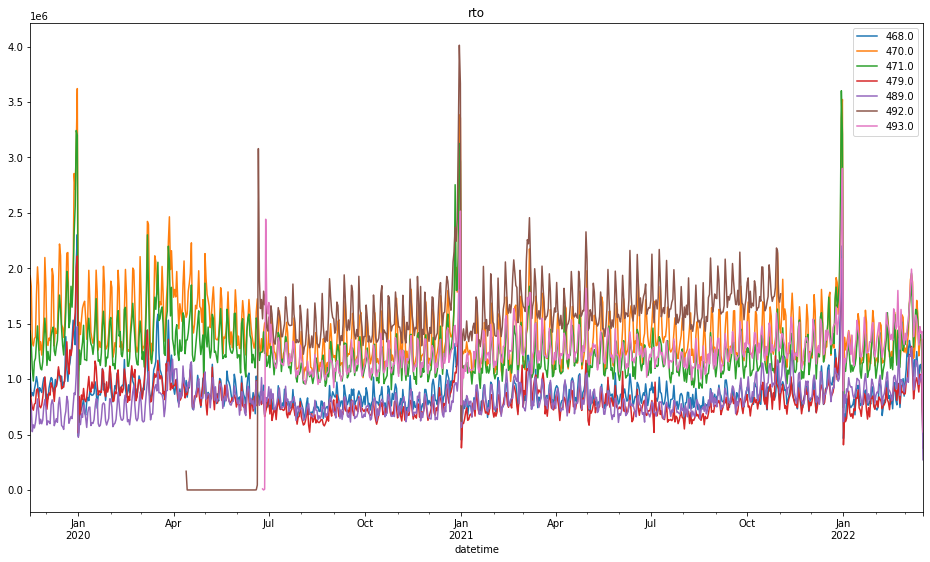

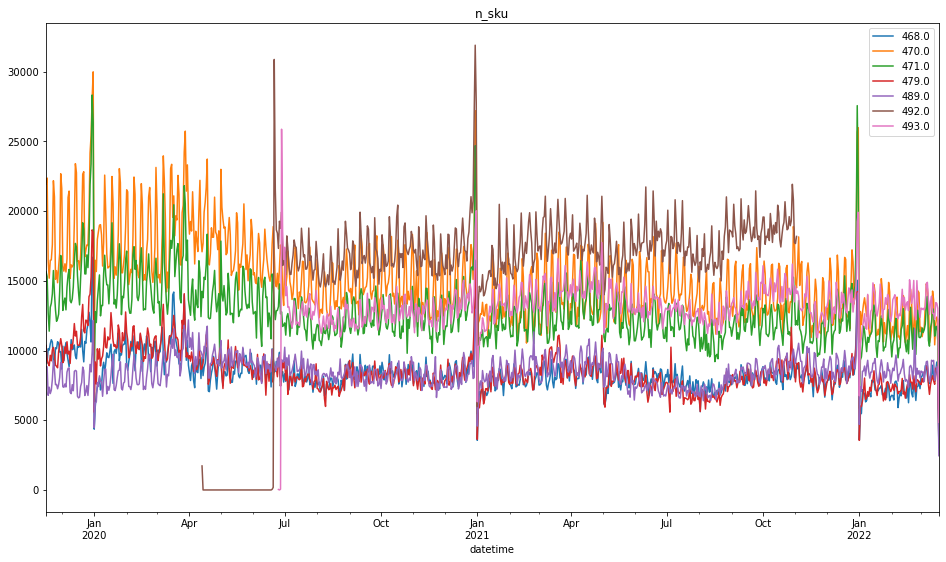

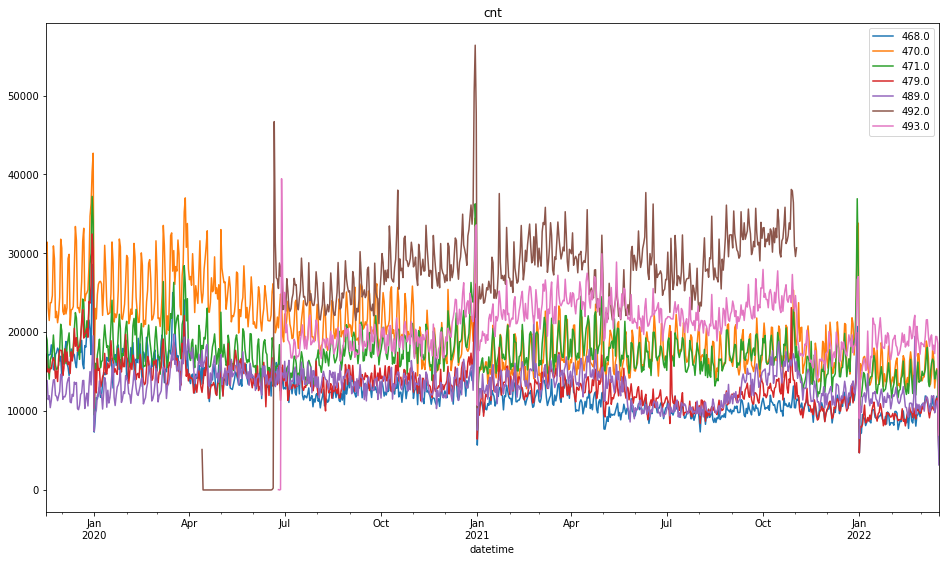

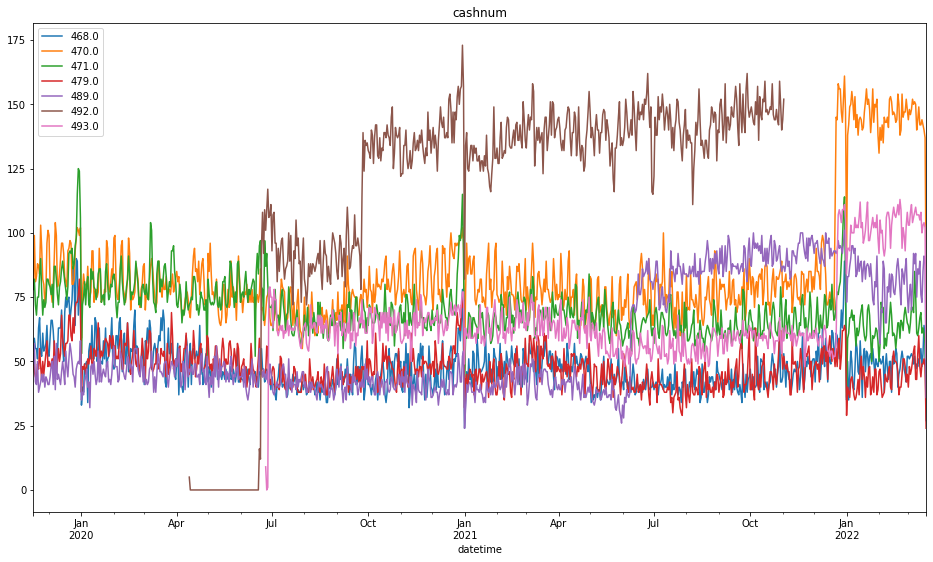

In [5]:
columns = ['cheques', 'rto', 'n_sku', 'cnt', 'cashnum']
for clmn in columns:
    for ou in df['ou'].unique():
        _df = df[df['ou']==ou]
        _df = _df.set_index('datetime').resample('D').sum()
        _df[clmn].plot(figsize=(16,9), label = f'{ou}')
    plt.title(f'{clmn}')
    plt.legend()
    plt.show()

In [9]:
outliers_fraction = 0.2
column = 'cheques'

### Anomaly weeks detector

In [7]:
def anomaly_week_detector(df, column, outliers_fraction=0.1):
    _df = df.copy()
    dfw = _df.groupby(_df.index.weekday).mean()
    dfw = dfw/dfw.sum()
    dfw = dfw.reset_index().rename(columns={'datetime':'dw', column:'tmpl'})

    _df['dw'] = _df.index.weekday
    _df['w'] = _df.index.year*100 + _df.index.week

    d1 = _df.groupby('w')[column].sum().reset_index()
    d1.rename(columns={column: 'v_sum'}, inplace=True)
    ddf = _df.merge(d1)
    ddf['v_norm'] = ddf[column] / ddf['v_sum']
    ddf['v_norm_sqr'] = ddf['v_norm']*ddf['v_norm']
    ddf = ddf.merge(dfw)
    ddf['tmpl_sqr'] = ddf['tmpl']*ddf['tmpl']
    ddf['n_tmpl'] = ddf['tmpl']*ddf['v_norm']
    ddf = ddf.groupby('w')[['v_norm_sqr', 'tmpl_sqr', 'n_tmpl']].sum().reset_index()
    ddf['tmpl'] = np.sqrt(ddf['tmpl_sqr'])
    ddf['v_norm'] = np.sqrt(ddf['v_norm_sqr'])
    ddf['cos'] = (ddf['n_tmpl'] / (ddf['tmpl']*ddf['v_norm']))
    ddf['angle'] = ddf['cos'].apply(lambda x: math.acos(x))
    ddf['is_anomaly'] = ddf['angle'] >= ddf['angle'].quantile(q=1-outliers_fraction)

    df_out = _df.reset_index().merge(ddf[['w', 'is_anomaly']]).set_index('datetime')
    df_out['anomaly'] = df_out[df_out['is_anomaly']][column]

    return df_out

C:\Users\dmitry\.conda\envs\DS\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


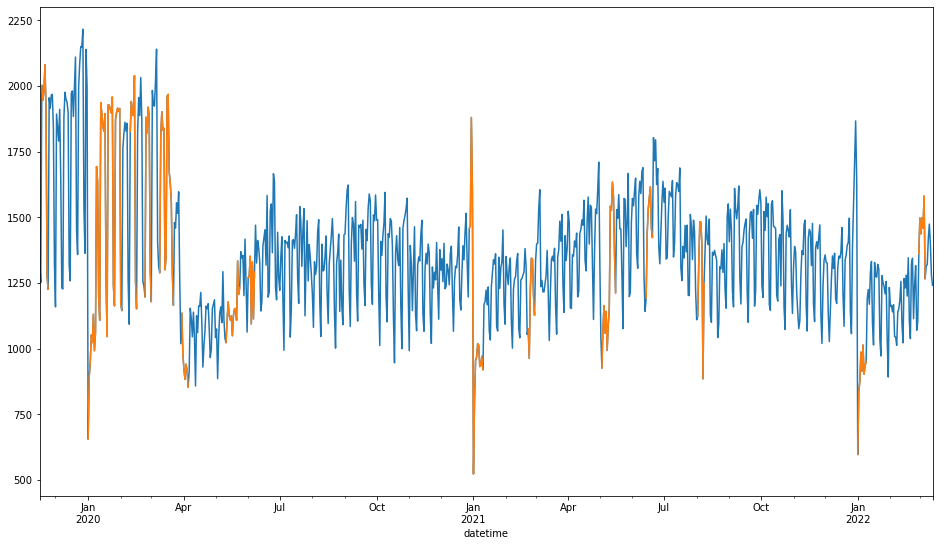

C:\Users\dmitry\.conda\envs\DS\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


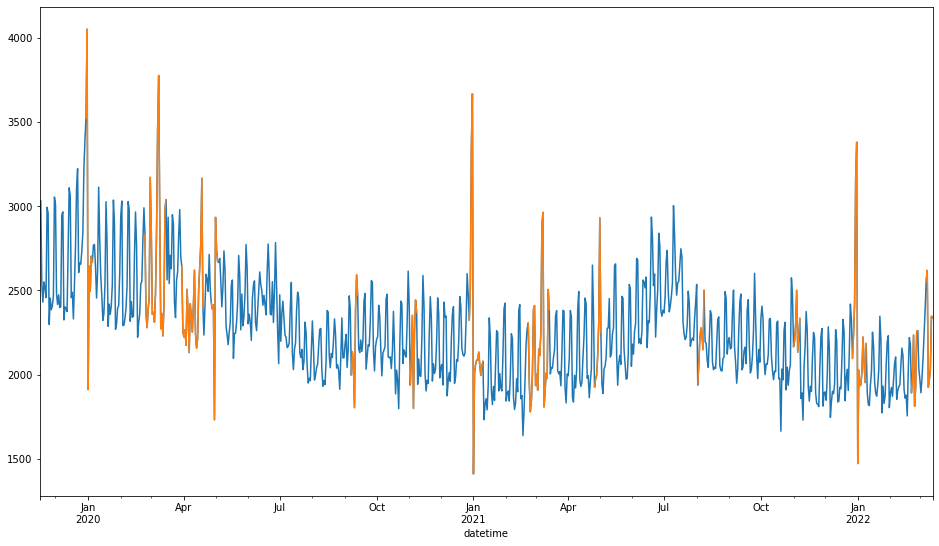

C:\Users\dmitry\.conda\envs\DS\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


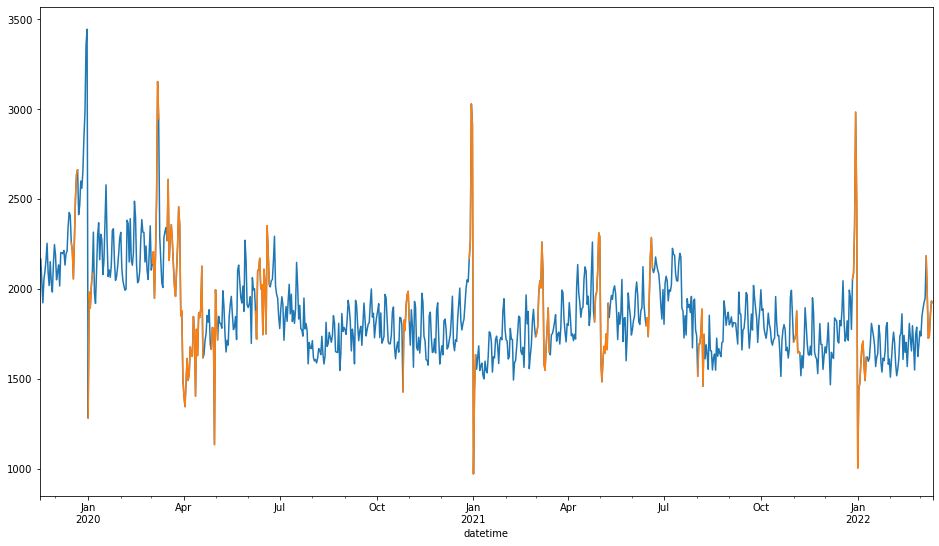

C:\Users\dmitry\.conda\envs\DS\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


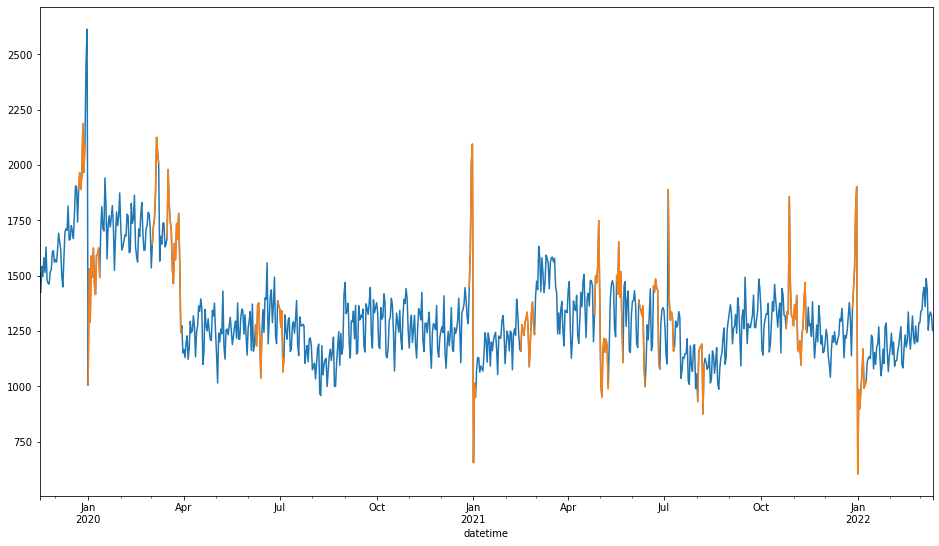

C:\Users\dmitry\.conda\envs\DS\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


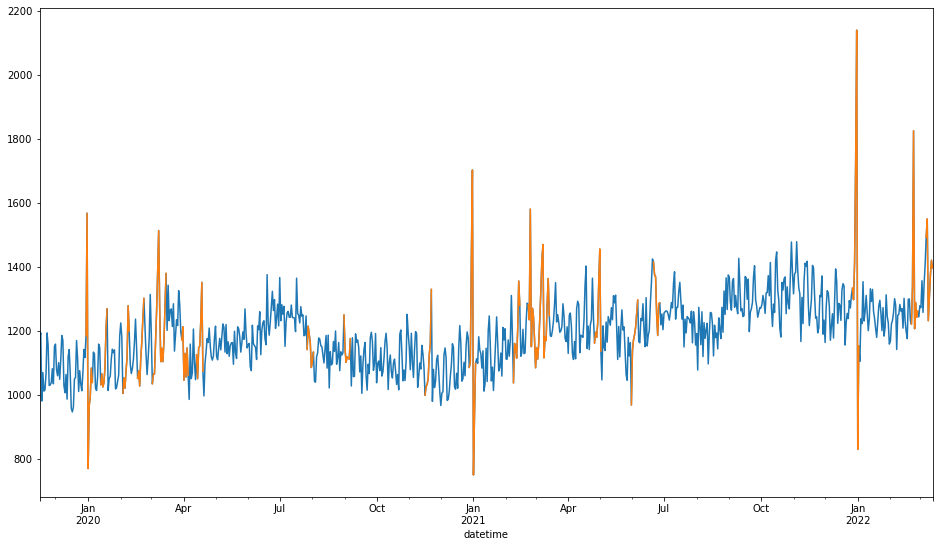

C:\Users\dmitry\.conda\envs\DS\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


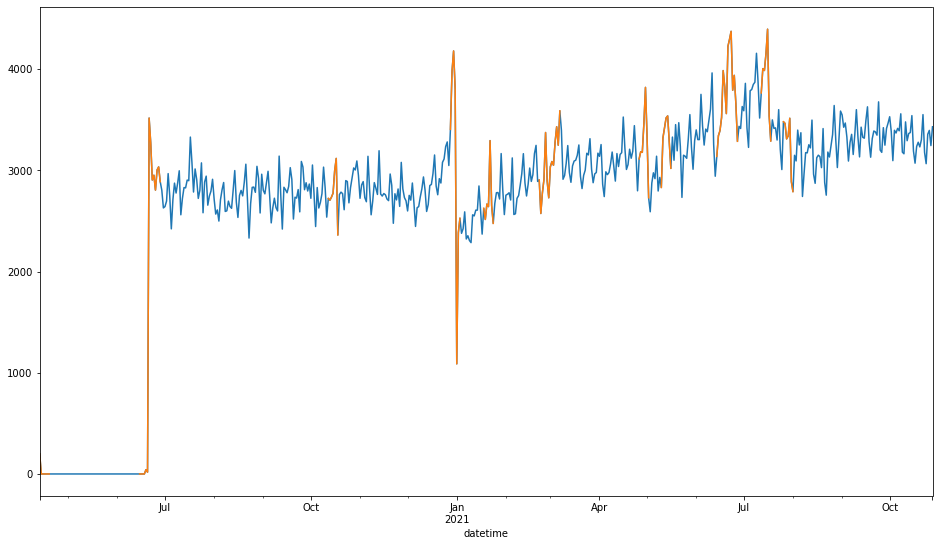

C:\Users\dmitry\.conda\envs\DS\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


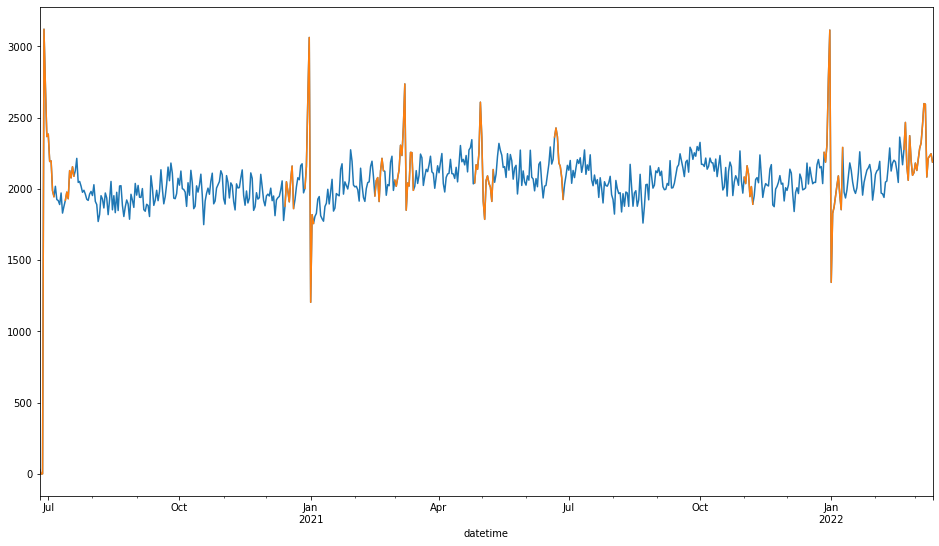

In [10]:
for ou in df.ou.unique():
    dd = df[df.ou==ou]
    dd = dd.set_index('datetime')
    dd = dd[[column]].resample('D').sum()
    dd = dd[:-5]

    df_outliers = anomaly_week_detector(dd, column, outliers_fraction=outliers_fraction)

    df_outliers[column].plot(figsize=(16,9))
    df_outliers['anomaly'].plot(figsize=(16,9))
    plt.show()